# Premature Optimization - And All That
A word of warning: if you're playing Valorant and came for the magic of better results then you're in the wrong place. Fundamentals are where you should be spending your time and not on tricks which grant minor advantages over players at your own skill level. Granting that this post does what I expect it to - namely, that optimizing the color of a player's crosshair on a per map basis will net some kind of advantage - then applying this wont help you if you cannot shoot. Tracking your crosshair matters - but it matters less than your accuracy and your mental.

# On To The Show
I watching a good amount of Valorant players and one of the details which higher tier players tend to obsess over are configuration settings which augment their ability to play the game. A heavy focus is placed on mouse sensitivity, frame rates, color overlays: increasing and refining the amount of vital information on screen. Today we're going to test an idea: Given any map, what color should your crosshair be to efficiently track it while aiming?

# The Method
There are a couple parts to how this will need to work. Firstly, we'll need to be able to pull in an image, then convert it into a numeric representation and then run some form of aggregation on the image. Once we have that working, we'll move on to iterating through a collection of images take from the maps in question and then aggregating the aggregation to find the most common color. With this, we can then seek a contrasting color to use as the crosshair color.

## Draw With Numbers.
Firstly, we'll want to understand how to draw and image so when we start importing images we will be able to manipulate and visualize them. An image is nothing more than a height, a width an a color value for each pixel. So, if you wanted an image which is 10x10 then we would do the following:

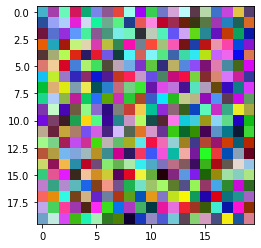

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# generate test data
test_data = np.random.beta( size = [100, 100, 3], a = 1, b = 1)

# display the test_data
plt.imshow(test_data[0:20, 0:20, :]);

We can run this over and over again to get different results. What this is doing is taking random numbers from the **Beta Distribution** and then filling an array of 100 rows by 100 columns with another dimension of size 3. This is very important to remember because this is called the array's *shape* in `numpy` parlance. And, to get images to display you will need to be very careful about what dimensions are where. In this case, the arrangement is the **Height**, then the **Width** and then the **Color** - or *Depth* if you prefer.

In [3]:
test_data.shape

(100, 100, 3)

Remember: **The shape must look like this or else you get nothing.** We'll see once we start working with tensors that this order is not maintained.

## Aggregation Of An Image/Array
So, what we really want is the average color of the pixel on the screen. There are different kinds of average but we'll use the *Arithmatic Mean* since that is what most people think of average. In the future, we may try out others and see if they're better but maybe tomorrow.

Getting the mean of an array is very easy thanks to numpy; we just run `.mean()` and we get what we want - or do we?

In [4]:
test_data.mean()

0.4985771653927345

So, this number is nice but it doesn't mean anything. And, that's because we don't want the mean of all the dimensions but really only along the height and width. We want to keep the color dimenion since that is what we're actaully after. the `mean()` function allows us to specify the axis to calculate the mean of:

In [5]:
test_data[0:10, 0:10, :].mean( axis=(0, 1))

array([0.55203737, 0.52206348, 0.4831622 ])

Excellent! So, now we just need to fill some kind of image with these values and we can see the color! 

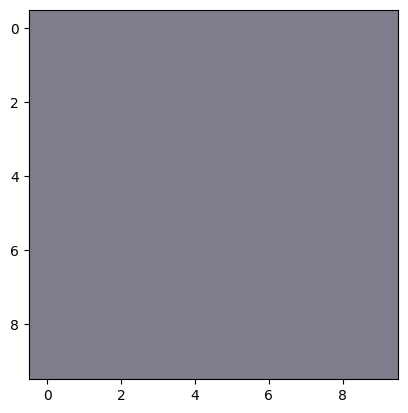

In [11]:
cup = np.random.beta( size = [10, 10, 3], a = 1, b = 1)
cup[::] = test_data[0:10, 0:10, :].mean( axis=(0, 1))
plt.imshow(cup);

Since the data is random, seeing some form of grey here makes sense.

## Lets Meet Alex
Now we'll need real data now and we get that from the real world. Meet Alex.

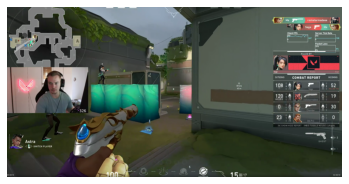

In [2]:
#| echo: false
#| info: false

from PIL import Image
alex = Image.open("images/2022-12-15/alex-collect.png")
plt.axis("off")
plt.margins(x=0,y=0)
plt.imshow(alex);

Alex plays Valorant on Twitch. Alex is *very good* at Valorant. <br />
Sign [FakeAnanas](https://www.twitch.tv/fakeananas).

With Alex's permission, I used some of his footage from Twitch to turn one of his streams into images for this idea. To convert the video to images I used `ffmpeg` which is a pretty common tool used in programs like OBS and other video tools. I created bunch of images from the frames using `ffmpeg -i collected-alex.mp4 -vf fps=5 alex%d.png` which extracted out hundreds of thousands of images for our use. 

So, we have our aggregation and we have our image so let's test this out: can we insert the average color into the image and split the image?

In [4]:
# Get the shape of the image; find the middle of each dimension
alexShape = np.array(alex).shape

# numpy requires these be ints
midHeight, midWidth = int(alexShape[0]/2), int(alexShape[1]/2)
midHeight, midWidth

(643, 1266)

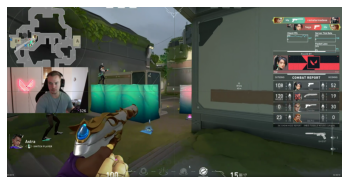

In [5]:
# Convert to a real array
sample = np.array(alex)
meanColor = tuple(sample.mean(axis=(0,1)))

sample[midHeight,:,:] = meanColor
sample[:,midWidth,:] = meanColor

plt.axis('off')
plt.imshow( sample );

If you look carefully, the color inserts are there but hard to see. Let's make them a bit wider and try again. Lets add make the line 16 pixels wide on both dimensions.

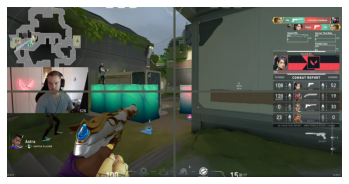

In [6]:
offset=8

sample[midHeight-offset:midHeight+offset,:,:] = meanColor
sample[:,midWidth-offset:midWidth+offset,:] = meanColor

plt.axis('off')
plt.imshow( sample );

## What is Contrast Really?
So, in laymen's terms **Contrast** is when it is easy to distinguish between two parts with respect to colors. Two obvious examples would be the colors red and blue next to one another; you're not going to struggle to tell where the blue nor the red is. But, I found [this article](https://www.accessibility-developer-guide.com/knowledge/colours-and-contrast/how-to-calculate/) easy enough for my poorly trained artistic understanding does a good job of outlining that *contrast is not really about colors at all but actually about the luminosity - or the amount of light in the colors*. The formula for this is pretty simple but thankfully the Python Image Library can already do this for us with `ImageEnhance`!


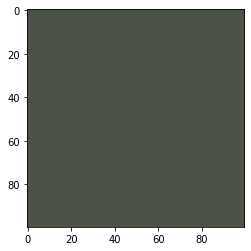

In [7]:
from PIL import Image, ImageEnhance

# Reset:
sample = np.array(alex)

height, width, channels = 100, 100, 3
image_blank = np.zeros((height, width, channels), np.uint8)
image_blank[::] = tuple(sample.mean( axis=(0,1)))
plt.imshow(image_blank);

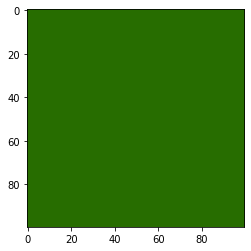

In [8]:
# Increase the contrast; make it really different!
im = Image.fromarray(image_blank)
imC = ImageEnhance.Contrast(im)
plt.imshow(imC.enhance(10));

That should be much better so let's insert that instead into our older image and see if it stands out.

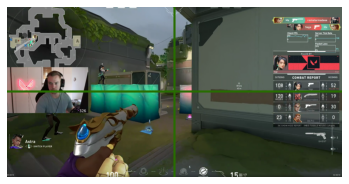

In [9]:
contrastColor = tuple(np.array(imC.enhance(10))[0,0,:])

sample[midHeight-offset:midHeight+offset,:,:] = contrastColor
sample[:,midWidth-offset:midWidth+offset,:] = contrastColor

plt.axis('off')
plt.imshow( sample );

Look how much better that is!

## Bricks 'N Clay
Ok, so now just need lots of images. Luckily, I already have those in the samples collected so now we just need some way to use them. This is the dirty part of all this which is not fun: getting, organizing and cleaning data. In this instance, cleaning is not really necessary as the data is about as ideal as it can get. We need to tag the images and pick a map to start with.

In [10]:
#| include: false 
path = '/home/shoklan/Documents/Datastore/Images/Alex/images/'

Much of the time labels come in a CSV file which contains a pairing of the data and the label: in this case the image and the map. So, we'll have to create this from scratch. First, we'll get all the files we've collect and then add them to dictionary where the `image` is one value and a blank `map` value is the other. This will allow us to insert the values manually - yes manually - for the images. We'll `glob` for files which end in `.png` and then create the dictionary from them.

In [11]:
from pathlib import Path

dataDirectory = Path( path )
targetFiles = sorted( dataDirectory.glob('*.png') )

# This returns a generator so you'll need to re-run it after you sanity check it
images = map( lambda x: {'image':x.name, 'map':''}, targetFiles)
next( images )

{'image': 'alex00001.png', 'map': ''}

### Data Problems
If you've used `ffmpeg` before and you noticed that something was wrong with the name of that file then good on you! This was actually a problem that I had to solve; namely that sorting by name created a problem where images were not showing up in what would of been assumed the proper order. A snippet of what happened when you sorted them before is:
```
[PosixPath('###/images/alex1.png'),
 PosixPath('###/images/alex10.png'),
 PosixPath('###/images/alex100.png'),
 PosixPath('###/images/alex1000.png'),
 PosixPath('###/images/alex10000.png'),
 PosixPath('###/images/alex10001.png'),
 PosixPath('###/images/alex10002.png'),
 PosixPath('###/images/alex10003.png'),
 PosixPath('###/images/alex10004.png'),
 PosixPath('###/images/alex10005.png')]
```

The files are not being sorted in numerical order as would be expected becuase as far as the computer was concerned `alex1.png` and `alex10.png` where adjacent and not `alex2.png`. This makes the labeling impossible since the order is wrong. And, it was startling when I started trying to label everything when the images loaded were so random.

To fix this, we'll need to expand the name of the file out and replace it with 0 filled names. First we needed to find the largest number to fill out to:

In [46]:
# Get the files:
files = dataDirectory.glob('*.png')
aSomething = [x.name for x in files]

# Split off and sort by numbers:
filenames = sorted( aSomething, key = lambda x: int(x.split('.')[0].replace('alex', '')))

# Find the largest number
filenames[-1]

'alex53278.png'

So, now we know there are up to five digits we'll need to fill. Thankfully, python already has a function to do this for us: `zfill()`. This will take a number as a string and then fill that string out. It can do other things as well but it is mainly for formatting text output - which we want to do here.

In [47]:
'1'.zfill(5)

'00001'

Now we'll test this to make sure it works:
```python
list(
    map(lambda x: str(x.parent/'alex') + x.name\
            .split('.')[0]\
            .replace('alex', '')\
            .zfill(5)+'.png',
        targetFiles[:10]))
```
```
['###/images/alex00001.png',
 '###/images/alex00010.png',
 '###/images/alex00100.png',
 '###/images/alex01000.png',
 '###/images/alex10000.png',
 '###/images/alex10001.png',
 '###/images/alex10002.png',
 '###/images/alex10003.png',
 '###/images/alex10004.png',
 '###/images/alex10005.png']
```

And, it does! Now we just move the files to fix their names:
```python
import shutil as fm

for filename in targetFiles:
    newFileName = str(filename.parent/'alex') + filename.name.split('.')[0].replace('alex', '').zfill(5)+'.png'
    fm.move(filename, newFileName)
```

### Back To Our CSV
So, now we can return to making the CSV file we'll be putting out labels in:

In [ ]:
targetFiles = sorted( dataDirectory.glob('*.png') )

# This returns a generator so you'll need to re-run it after you sanity check it
images = list(map( lambda x: {'image':x.name, 'map':''}, targetFiles))

# And, our blank csv for labels:
imageSolutions = pd.DataFrame(images)
imageSolutions.to_csv(dataDirectory/'alexImages.csv', index=False)

And, now the non-fun of labeling the data by typing entries into the CSV. I'm only going to do Ice Box in this post since it was the first map I ran across while reviewing the data. So, we'll focus on just that map. I went ahead and labeled some of the images for Icebox and left the others as blank.

## Inserting PyTorch Datasets
This is the unnecessary part of this post; I wanted to play around with this to better understand this `Dataset` class as a general tool. Pytorch comes with something called a *Dataset* which a simple way to encapsulate the data being used. You can think of it as front end API to a dataset. And, that's exactly how I'm going to use it.

Per the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), this class needs to implement three functions: `__init__`, `__len__` and `__getitem__`. To keep with our *Front End* idea:

* `__init__` does the processing of the data.
* `__len__` tells you how many there are.
* `__getitem__` gives you one of your data from the dataset.

In the example, all the configuration details are included when you create the object: where the labels can be found, where the data is being stored and what transforms should be applied when an item is called. Note that *none* of the transforms are ran when the object is created but instead are ran when one of the data is asked for. We're not actually going to be putting the calculation of the means into the transforms - but we could definitely do that instead of iterating through and processing them.

First, we're going to need to define the `__init__` part of our object; what do we want this to do? Again, we want it to:
1. Store where the data is.
2. Tell it where to find the labels for the data.

I will be adding another function to my dataset: filtering based on map. Right now, I only have one map to work with and I don't want to think about the others yet. And, as more data is added I want to be able to ask only for specific maps per dataset. So, we'll want a filter in here too.

```python
class ImageAverageDataset(Dataset):
    def __init__(self, annotations, directory, filter=None):
        self.data = pd.read_csv(directory/annotations)
        self.directory = directory
        # here is our filter; we will need to define this function still.
        self.data = self.imageFilter(self.data, filter)
```
Implementing the length is easy enough:
```python
def __len__(self):
    return len(self.data)
```
... and lastly we want to be able to ask for samples from specific maps:
```python
def imageFilter(self, data, filter):
        return data.query(f'map == "{filter}"')
```

Putting this all together with the imports and we have our Dataset class for our project.

In [12]:
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image


class ImageAverageDataset(Dataset):
    def __init__(self, annotations, directory, filter=None):
        self.data = pd.read_csv(directory/annotations)
        self.directory = directory
        self.data = self.imageFilter(self.data, filter)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = tuple(self.data.iloc[idx])
        tensor = read_image( str(self.directory) + '/' + image)
        return tensor, label

    def imageFilter(self, data, filter):
        return data.query(f'map == "{filter}"')

Excellent! Now we just point this at where our data and our annotations file are to create it:
```python
icebox = ImageAverageDataset('alexImages.csv', dataDirectory, 'Icebox')
```

In [13]:
#| include: false
icebox = ImageAverageDataset('alexImages.csv', dataDirectory, 'Icebox')

Let's pull one of them!
```python

plt.imshow(icebox[10])

# ...

TypeError: Image data of dtype <U6 cannot be converted to float
```

Ah, we're getting both a label and an array back. But also, is that really an array? Recall that I had mentioned much earlier that tensors don't maintain the dimensions? Here they are!

In [53]:
type(icebox[10][0])

torch.Tensor

So, what is a **Tensor** anyways? Well, these are what *Pytorch* calls arrays and is a different implementation of the same idea. *Tensors* come from Physics and were the initial inspiration for all this decades ago. And, the assumptions are not the same between `numpy` and `torch`. In the code above there is a call to the function `read_image()` and this takes the image and converts it into a *tensor* and **not** an array. When we look at the shape this will be more obvious.

In [54]:
icebox[10][0].shape

torch.Size([3, 1080, 1920])

So, the color is the first dimension now instead of the last dimension for the images we worked with before. This is a problem because when we try to display the image it wont know what to do with this. The fastest way I have found to solve this is with a call to `.swapaxis()` which will change the shape by reordering the dimensions.

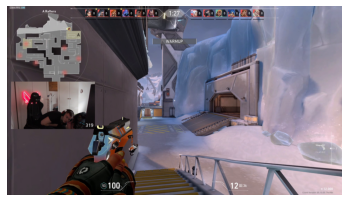

In [14]:
plt.axis('off')
plt.imshow(icebox[10][0].moveaxis(0,2));
# Dont actually need to convert to .numpy() and it still works fine.
# I didn't know that but hurray!

### Generalize this all.
And, now we come to the fun part: calculations and the conclusions. All we need now is to iterate through our dataset collecting the mean color for each image. Then, take another mean of all the color values to get our average color across all images. We've seen most of this before so here is the code for it:

In [16]:
# tuple(np.mean(np.array(alex)[:, :, :], axis=(0,1)))
def getMeanColor(img):
    """Convert the tensor and get the mean color"""
    return tuple(
        img.moveaxis(0,2).numpy().mean(axis=(0,1))
    )

container = pd.DataFrame({'y':[], 'x':[], 'c':[]})
for i in range(len(icebox)):
    container.loc[i, :] = getMeanColor(icebox[i][0])

You may think - being a quality pythonista - that you could iterate through each image instead of using an index like I have. Well, I tried that initially and these datasets don't implement the necessary functions to be a generator. When trying that, I kept getting the labels from the CSV instead of the data. I'm not sure the how or why but you're welcome to add those to the function if you're - ahem - *borrowing* this for your own projects. Or, do what I did since that works too.

Next we calculate the mean of all the images and store that in a new image to display.

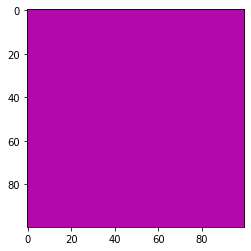

In [17]:
height, width, channels = 100, 100, 3
image_blank_new = np.zeros((height, width, channels), np.uint8)
image_blank_new[::] = container.sum(axis=0) # tuple(np.mean(np.array(alex)[:, :, :], axis=(0,1)))

plt.imshow( image_blank_new );

AND ENHANCE!

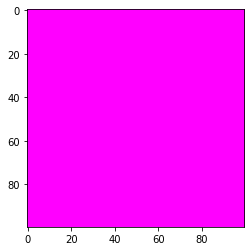

In [18]:
im_new = Image.fromarray(image_blank_new)
imC_new = ImageEnhance.Contrast(im_new)
plt.imshow(imC_new.enhance(10));

I didn't think that Ice Box had a pink tint to it but that's what the results are. Now we'll want to get this color and then convert it to a hexcode for use. Again, python comes to the resuce as `matplotlib` has a function to do this once we've corrected the color.

In [63]:
from matplotlib.colors import rgb2hex
np.array(imC_new.enhance(10)).mean(axis=0)[0]/255
rgb2hex(np.array(imC_new.enhance(10)).mean(axis=0)[0]/255)

'#ff00ff'

# Conclusion
And there you go! The color `#ff00ff` should be an excellent contrasting color to be used on Icebox if this all works as intended. Try it out for yourself and see if this actually works!

So, after doing all this work I was curious to see if anyone else had tried this analysis out. And, [someone beat me by a few months](https://www.reddit.com/r/VALORANT/comments/x3ok8b/optimal_crosshair_colors_based_on_customs_game/?utm_term=2001568619&utm_medium=post_embed&utm_source=embed&utm_name=&utm_content=header). Interestingly, their methods were different than mine and - at least for Icebox - they got a completely different result. Looking over what they did, I've got some critiques which I'll discuss in a second post - along with my own conclusions for the other maps. For now, try them both out and see which works better.